# Supervised Repertoire Classification

While solving a sequence classification can be useful in the cases where the label applies to every sequence in a sample (such as in tetramer-sorted T-cells), there are times where the label may truly only apply to a set of sequences. For example, in the case where one may sequence tumor-infiltrating lymphocytes (TIL) and  there is a label at the repertoire/sample level such as which therapy the sample received. In this case, there may be a structural signature within a set of sequences that is predictive but not every single sequence has that signature. This is a case where we want to learn what is the structural signature buried in a set of sequenes and which sequences carry this signature.

To demo this utility of a repertoire/sample level classifier, we will first upload dat from the Rudqvist dataseet. In this dataset, 20 mice with implanted tumors were treated with 4 modes of therapy (Control, 9H10, RT, or Combo). We want to know whether the TCRrepertoire from their tumors is predictive of the therapy they received.

In [9]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

Loading Data...
Embedding Sequences...
Data Loaded


Following loading the data, we will split our data into test/train and then train the model.

In [10]:
DTCR_WF.Get_Train_Valid_Test(test_size=0.25)
DTCR_WF.Train()

Training_Statistics: 
 Epoch: 0 Training loss: 1.69073 Validation loss: 1.65465 Testing loss: 1.66149 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.16667
Training_Statistics: 
 Epoch: 1 Training loss: 1.65315 Validation loss: 1.61878 Testing loss: 1.62735 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.16667
Training_Statistics: 
 Epoch: 2 Training loss: 1.61934 Validation loss: 1.58327 Testing loss: 1.59386 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.16667
Training_Statistics: 
 Epoch: 3 Training loss: 1.58589 Validation loss: 1.54716 Testing loss: 1.55951 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.25
Training_Statistics: 
 Epoch: 4 Training loss: 1.55172 Validation loss: 1.51087 Testing loss: 1.52425 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.33333
Training_Statistics: 
 

Following training, we can view the performance through plotting the ROC curves.

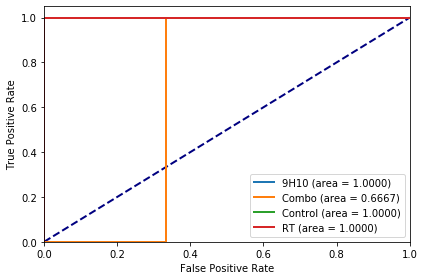

In [12]:
DTCR_WF.AUC_Curve()

You might notice that given how small this dataset is, doing one training split does not give us a good assesment for how predictive the TCR signature may be. In this case, we would want to use a K-fold cross validation to train on 16 of the samples and test on 4 and iterate until we've covered the entire cohort. When calling the K-fold cross validation command, one can provide the number of folds or if none is provided, it assumes a leave-one-out strategy. Therefore, we will set the folds to 5 where each fold will contain 4 samples. Here, we will also utilize an option for training where we apply a hinge loss to the training data where the per-sample loss is only used to penalize the model if it is above a certain threshold. This prevents over-fitting of the neural network. The idea here is that once a sample has been called correctly, there is no additional benefit to get it 'more right'. This is a particularly good training strategy when we are working with small datasets such as this one. We will also set the combine_train_valid parameter to True to combine what was originally the train and validation sets into one training set while leaving the test set for assessing performance. Otherwise, this method normally applies an early stopping criterion on the validation set. Since we have combined our train and validation sets together, we need to apply a stopping criterion on this training data. We will set the minimum loss before stopping training on the training data to 0.1. This means that when the average training loss hits 0.1, the neural network will stop training.

Here, we will also introduce other hyper-parameters we can modify including changing the size of the network. The size of the network parameter chooses the number of nodes for the 3 convolutional layers. Here, we will switch the size of the network to 'small' which use 12,32,64 nodes respectively for the 3 conv layers. We will also leave out 4 samples for testing while we use 16 for training. Finally, we will also train our model with 64 concepts, a hyper-parameter of the multiple-instance learning (MIL) algorithm that we can change depending on the level of heterogeneity we expect in our data.

In [13]:
%%capture
folds = 5
size_of_net = 'small'
num_concepts=64
hinge_loss_t = 0.1
train_loss_min=0.1
DTCR_WF.K_Fold_CrossVal(combine_train_valid=True, hinge_loss_t = hinge_loss_t,train_loss_min = train_loss_min,folds=folds,
                       num_concepts=num_concepts, size_of_net=size_of_net)

INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_1/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_2/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_3/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_4/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


We can then assess the performance once again through plotting the ROC curves.

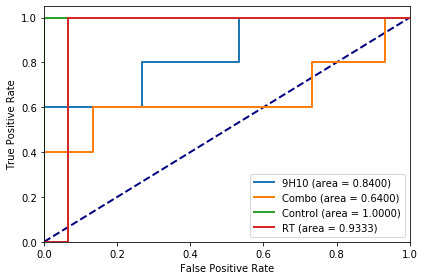

In [14]:
DTCR_WF.AUC_Curve()

We can also train our model in a Monte-Carlo fashion where we perform N number of monte-carlo simulation, randomly sampling train/test sets to train our model and assess predictive signature in our data in a more granular way.

In [15]:
%%capture
folds = 25
LOO = 4
epochs_min = 10
size_of_net = 'small'
num_concepts=64
hinge_loss_t = 0.1
train_loss_min=0.1

DTCR_WF.Monte_Carlo_CrossVal(folds=folds,LOO=LOO,epochs_min=epochs_min,num_concepts=num_concepts,size_of_net=size_of_net,
                             train_loss_min=train_loss_min,hinge_loss_t=hinge_loss_t,combine_train_valid=True)

INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_1/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_2/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_3/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_4/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_5/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_6/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_7/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tutorial/models/model_8/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Tut

Once again, we can look at the performance via a ROC curve.

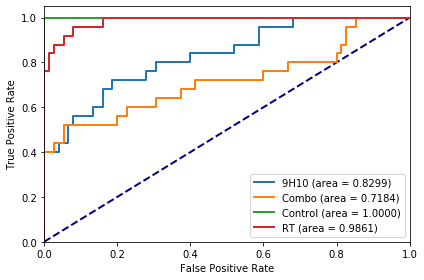

In [16]:
DTCR_WF.AUC_Curve()

Once our algorithm has been trained, we may want to see which sequences are the most strongly predicted for each label. To do this we will run the following command. The output of the command is a dictionary of dataframes within the object we can view. Additionally, these dataframes can be found in the results folder underneath the subdirectory 'Rep_Sequences'.

In [17]:
DTCR_WF.Representative_Sequences()

In [18]:
print(DTCR_WF.Rep_Seq['Control'])

      alpha            beta v_alpha j_alpha      v_beta      d_beta  \
10858  None    CASGAWGYEQYF    None    None  TCRBV13-02  unresolved   
12118  None   CASSLGLYAEQFF    None    None  TCRBV13-01  unresolved   
14309  None   CASSLGGRDEQYF    None    None  TCRBV03-01  TCBDD02-01   
10896  None    CASALGQYEQYF    None    None  TCRBV13-02  TCBDD01-01   
13694  None    CASGAWGYEQYF    None    None  TCRBV13-02  unresolved   
13261  None    CASGAWGYEQYF    None    None  TCRBV13-02  unresolved   
11720  None  CASGLQMGKYEQYF    None    None  TCRBV13-02  unresolved   
10860  None  CASSLWDSSYEQYF    None    None  TCRBV24-01  TCBDD01-01   
12127  None  CASSLWDSSNEQYF    None    None  TCRBV24-01  TCBDD01-01   
13641  None   CASSIGLYAEQFF    None    None  TCRBV13-01  unresolved   

           j_beta    Class         Sample      Freq  Counts           HLA  \
10858  TCRBJ02-07  Control  CONTROL-1.tsv  0.057541     132  [N, o, n, e]   
12118  TCRBJ02-01  Control  CONTROL-1.tsv  0.000436       1  [N,

Furthermore, we may want to know which learned motifs are associated with a given label. To do this, we can run the following command with the label we want to know the predictive motifs for.

In [19]:
DTCR_WF.Motif_Identification('Control')

Motif Identification Completed


The motifs can then be found in fasta files in the results folder underneath (label)(alpha/beta)Motifs. These fasta fiels can then be used with "https://weblogo.berkeley.edu/logo.cgi" for motif visualization.